<a href="https://colab.research.google.com/github/GuyFarb/Cars-Project/blob/main/Transfer_ResNet50.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.applications import ResNet50,VGG19
from tensorflow.keras.layers import Dense ,GlobalAveragePooling2D,Dropout,GlobalMaxPool2D
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt


In [3]:
train_tfrecord_path = "/content/drive/MyDrive/Car196_project/processed_cars196/cars196_train.tfrecord"
test_tfrecord_path = "/content/drive/MyDrive/Car196_project/processed_cars196/cars196_test.tfrecord"


In [4]:
def parse_tfrecord(example):
    feature_description = {
        "image": tf.io.FixedLenFeature([], tf.string),  # תמונה בפורמט bytes
        "label": tf.io.FixedLenFeature([], tf.int64)    # תווית המחלקה
    }

    example = tf.io.parse_single_example(example, feature_description)
    image = tf.image.decode_jpeg(example["image"], channels=3)  # פענוח התמונה
    image = tf.image.resize(image, (224, 224))  # התאמת גודל
    image = tf.cast(image, tf.float32) / 255.0  # נורמליזציה לערכים בין 0 ל-1
    label = example["label"]

    return image, label

# הגדרת משתני אימון
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

# טעינת הנתונים מה-TFRecord
train_dataset = tf.data.TFRecordDataset(train_tfrecord_path)
train_dataset = (train_dataset
    .map(parse_tfrecord, num_parallel_calls=AUTOTUNE)
    .shuffle(1000)
    .prefetch(AUTOTUNE)
)

test_dataset = tf.data.TFRecordDataset(test_tfrecord_path)
test_dataset = (test_dataset
    .map(parse_tfrecord, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

print("✅ קובצי ה-TFRecord נטענו בהצלחה!")

✅ קובצי ה-TFRecord נטענו בהצלחה!


In [5]:
def augment(image, label):
    image = tf.image.random_flip_left_right(image)  # היפוך אופקי
    image = tf.image.random_brightness(image, max_delta=0.2)  # שינוי תאורה
    image = tf.image.random_contrast(image, lower=0.8, upper=2)  # שינוי קונטרסט
    image = tf.image.random_saturation(image, lower=0.8, upper=2)  # שינוי רווייה
    image = tf.image.random_jpeg_quality(image, min_jpeg_quality=80, max_jpeg_quality=100)  # איכות תמונה

    return image, label

# החלת האוגמנטציה על הנתונים לפני ה-Batching
train_dataset_augmented = (train_dataset
    .map(augment, num_parallel_calls=AUTOTUNE)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

print("✅ נוספה אוגמנטציה ל-Train Dataset!")

✅ נוספה אוגמנטציה ל-Train Dataset!


#RESNET50

In [3]:
base_model = (weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
  layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dense(196, activation='softmax')(x)

model=Model(inputs=base_model.input,outputs=x)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=["accuracy"]
)

print("✅ המודל nvמוכן לאימון!")
model.summary()  # הצגת מבנה המודל

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
✅ המודל nvמוכן לאימון!


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 56, 56, 64)     │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 64)     │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 64)     │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 56, 56, 64)     │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 56, 56, 256)    │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 56, 56, 256)    │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 24,162,628 (92.17 MB)

 Trainable params: 574,916 (2.19 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

In [7]:
import time


# מדידת זמן התחלת האימון
start_time = time.time()

# הרצת האימון
history = model.fit(
    train_dataset,  # נתוני האימון
    validation_data=test_dataset,  # נתוני הבדיקה
    epochs=10,  # מספר האפוקים
)

# חישוב זמן האימון
end_time = time.time()
training_time = (end_time - start_time) / 60  # המרת השניות לדקות

print(f"✅ האימון הסתיים! זמן כולל: {training_time:.2f} דקות")


Epoch 1/10
    255/Unknown 52s 103ms/step - accuracy: 0.0039 - loss: 5.4003

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


255/255 ━━━━━━━━━━━━━━━━━━━━ 81s 215ms/step - accuracy: 0.0039 - loss: 5.4000 - val_accuracy: 0.0046 - val_loss: 5.2817
Epoch 2/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 54s 153ms/step - accuracy: 0.0057 - loss: 5.2847 - val_accuracy: 0.0058 - val_loss: 5.2726
Epoch 3/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 41s 161ms/step - accuracy: 0.0073 - loss: 5.2745 - val_accuracy: 0.0090 - val_loss: 5.2664
Epoch 4/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 40s 156ms/step - accuracy: 0.0088 - loss: 5.2666 - val_accuracy: 0.0101 - val_loss: 5.2612
Epoch 5/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 82s 316ms/step - accuracy: 0.0080 - loss: 5.2593 - val_accuracy: 0.0109 - val_loss: 5.2560
Epoch 6/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 41s 156ms/step - accuracy: 0.0091 - loss: 5.2517 - val_accuracy: 0.0116 - val_loss: 5.2497
Epoch 7/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 41s 161ms/step - accuracy: 0.0098 - loss: 5.2428 - val_accuracy: 0.0119 - val_loss: 5.2435
Epoch 8/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 82s 160ms/step - accuracy: 0.0106 - loss: 5.2338 - val

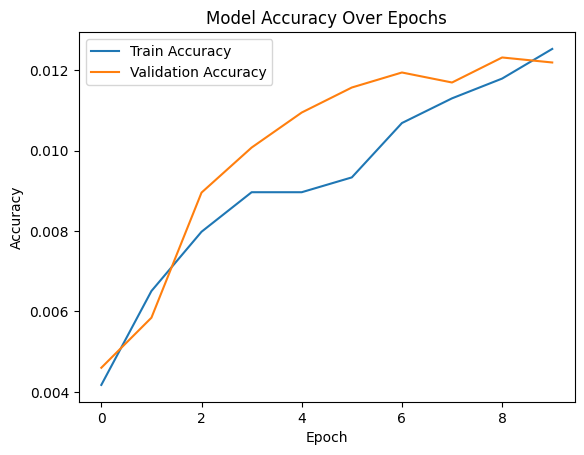

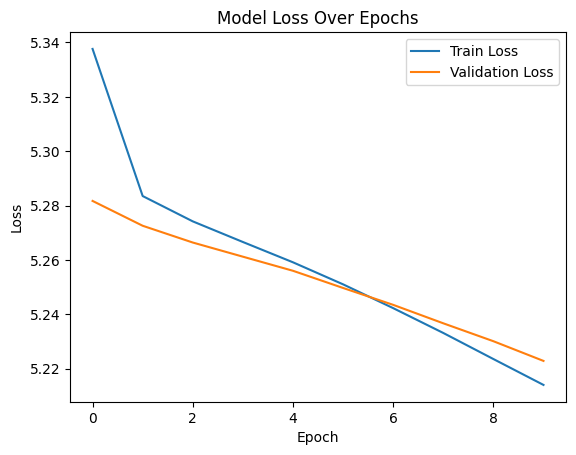

In [8]:
import matplotlib.pyplot as plt

# גרף דיוק (Accuracy)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy Over Epochs')
plt.show()

# גרף הפסד (Loss)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss Over Epochs')
plt.show()

switch model to EfficientNetB3

In [7]:
from tensorflow.keras.applications import EfficientNetB3
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model

base_model = EfficientNetB3(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers:
  layer.trainable = False

  x = base_model.output
  x = GlobalAveragePooling2D()(x)
  x = Dense(256, activation='relu')(x)
  x = Dense(196, activation='softmax')(x)

  model=Model(inputs=base_model.input,outputs=x)
  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=0.0001),
      loss='sparse_categorical_crossentropy',
      metrics=["accuracy"]
  )

print("✅ EfficientNetB0 מוכן לאימון!")
model.summary()



✅ EfficientNetB0 מוכן לאימון!


Model: "functional_385"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_2 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_1           │ (None, 224, 224, 3)    │              7 │ rescaling_2[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_3 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ normalization_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 225, 225, 3)    │              0 │ rescaling_3[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 40)   │          1,080 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 40)   │            160 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 40)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 112, 112, 40)   │            360 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 112, 112, 40)   │            160 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 112, 112, 40)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 40)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 40)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 10)       │            410 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 11,227,379 (42.83 MB)

 Trainable params: 443,844 (1.69 MB)

 Non-trainable params: 10,783,535 (41.14 MB)

In [8]:
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=10
)

Epoch 1/10
    255/Unknown 79s 140ms/step - accuracy: 0.0063 - loss: 5.2925

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


255/255 ━━━━━━━━━━━━━━━━━━━━ 113s 276ms/step - accuracy: 0.0063 - loss: 5.2925 - val_accuracy: 0.0060 - val_loss: 5.2777
Epoch 2/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 32s 127ms/step - accuracy: 0.0059 - loss: 5.2790 - val_accuracy: 0.0050 - val_loss: 5.2772
Epoch 3/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 41s 127ms/step - accuracy: 0.0048 - loss: 5.2773 - val_accuracy: 0.0053 - val_loss: 5.2768
Epoch 4/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 41s 160ms/step - accuracy: 0.0054 - loss: 5.2772 - val_accuracy: 0.0053 - val_loss: 5.2767
Epoch 5/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 41s 161ms/step - accuracy: 0.0081 - loss: 5.2770 - val_accuracy: 0.0092 - val_loss: 5.2764
Epoch 6/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 33s 128ms/step - accuracy: 0.0081 - loss: 5.2761 - val_accuracy: 0.0087 - val_loss: 5.2758
Epoch 7/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 41s 128ms/step - accuracy: 0.0082 - loss: 5.2757 - val_accuracy: 0.0085 - val_loss: 5.2754
Epoch 8/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 32s 127ms/step - accuracy: 0.0082 - loss: 5.2754 - va

In [9]:
# פתיחת 20 השכבות האחרונות של EfficientNet לאימון
for layer in base_model.layers[-20:]:
    layer.trainable = True

# קומפילציה מחדש עם קצב למידה קטן יותר
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

# הרצת אימון נוסף עם Fine-Tuning
history_fine = model.fit(train_dataset, validation_data=test_dataset, epochs=5)

Epoch 1/5
255/255 ━━━━━━━━━━━━━━━━━━━━ 108s 266ms/step - accuracy: 0.0062 - loss: 5.3054 - val_accuracy: 0.0076 - val_loss: 5.2763
Epoch 2/5
255/255 ━━━━━━━━━━━━━━━━━━━━ 90s 139ms/step - accuracy: 0.0049 - loss: 5.2871 - val_accuracy: 0.0061 - val_loss: 5.2746
Epoch 3/5
255/255 ━━━━━━━━━━━━━━━━━━━━ 41s 138ms/step - accuracy: 0.0072 - loss: 5.2790 - val_accuracy: 0.0086 - val_loss: 5.2722
Epoch 4/5
255/255 ━━━━━━━━━━━━━━━━━━━━ 41s 138ms/step - accuracy: 0.0083 - loss: 5.2762 - val_accuracy: 0.0086 - val_loss: 5.2707
Epoch 5/5
255/255 ━━━━━━━━━━━━━━━━━━━━ 41s 137ms/step - accuracy: 0.0085 - loss: 5.2736 - val_accuracy: 0.0083 - val_loss: 5.2700


In [14]:
from tensorflow.keras.applications import VGG19

base_model = VGG19(weights="imagenet",include_top=False,input_shape=(224,224,3))

for layer in base_model.layers:
  layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)  #againts Overfitting
x = Dense(196, activation='softmax')(x)

model=Model(inputs=base_model.input,outputs=x)
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=["accuracy"]
)

print("✅ VGG19 מוכן לאימון!")
model.summary()

✅ VGG19 מוכן לאימון!


Model: "functional_386"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_3 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 20,206,084 (77.08 MB)

 Trainable params: 181,700 (709.77 KB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [15]:
history = model.fit(
    train_dataset,
    validation_data=test_dataset,
    epochs=10
)

Epoch 1/10
    255/Unknown 110s 231ms/step - accuracy: 0.0058 - loss: 5.3799

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


255/255 ━━━━━━━━━━━━━━━━━━━━ 166s 453ms/step - accuracy: 0.0058 - loss: 5.3797 - val_accuracy: 0.0062 - val_loss: 5.2762
Epoch 2/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 117s 400ms/step - accuracy: 0.0067 - loss: 5.2860 - val_accuracy: 0.0119 - val_loss: 5.2577
Epoch 3/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 202s 639ms/step - accuracy: 0.0071 - loss: 5.2616 - val_accuracy: 0.0144 - val_loss: 5.2453
Epoch 4/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 141s 401ms/step - accuracy: 0.0124 - loss: 5.2414 - val_accuracy: 0.0152 - val_loss: 5.2319
Epoch 5/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 142s 400ms/step - accuracy: 0.0147 - loss: 5.2224 - val_accuracy: 0.0169 - val_loss: 5.2154
Epoch 6/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 202s 638ms/step - accuracy: 0.0164 - loss: 5.2048 - val_accuracy: 0.0209 - val_loss: 5.1984
Epoch 7/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 141s 399ms/step - accuracy: 0.0212 - loss: 5.1843 - val_accuracy: 0.0249 - val_loss: 5.1791
Epoch 8/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 202s 638ms/step - accuracy: 0.0279 - loss: 5.15

In [6]:
# טעינת מודל VGG19 ללא השכבות האחרונות
base_model = VGG19(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# הקפאת כל השכבות של המודל הבסיסי
for layer in base_model.layers:
    layer.trainable = False

# הוספת שכבות מותאמות
x = base_model.output
x = GlobalAveragePooling2D()(x)  # הפיכת המידע לוקטור ממוצע
x = Dense(512, activation="relu")(x)  # שכבה ללמידה נוספת
x = Dropout(0.3)(x)  # מונע Overfitting
x = Dense(196, activation="softmax")(x)  # סיווג ל-196 קטגוריות

# יצירת המודל הסופי
model = Model(inputs=base_model.input, outputs=x)

# קומפילציה
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

print("✅ VGG19 מוכן לאימון!")
model.summary()

✅ VGG19 מוכן לאימון!


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 20,387,588 (77.77 MB)

 Trainable params: 363,204 (1.39 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [11]:
history = model.fit(
    train_dataset_augmented,
    validation_data=test_dataset,
    epochs=15
)

Epoch 1/15
    255/Unknown 74s 232ms/step - accuracy: 0.0046 - loss: 5.3657

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


255/255 ━━━━━━━━━━━━━━━━━━━━ 130s 453ms/step - accuracy: 0.0046 - loss: 5.3656 - val_accuracy: 0.0095 - val_loss: 5.2667
Epoch 2/15
255/255 ━━━━━━━━━━━━━━━━━━━━ 137s 535ms/step - accuracy: 0.0055 - loss: 5.2838 - val_accuracy: 0.0139 - val_loss: 5.2452
Epoch 3/15
255/255 ━━━━━━━━━━━━━━━━━━━━ 142s 535ms/step - accuracy: 0.0119 - loss: 5.2532 - val_accuracy: 0.0174 - val_loss: 5.2224
Epoch 4/15
255/255 ━━━━━━━━━━━━━━━━━━━━ 107s 398ms/step - accuracy: 0.0162 - loss: 5.2197 - val_accuracy: 0.0187 - val_loss: 5.1978
Epoch 5/15
255/255 ━━━━━━━━━━━━━━━━━━━━ 202s 634ms/step - accuracy: 0.0190 - loss: 5.1903 - val_accuracy: 0.0261 - val_loss: 5.1698
Epoch 6/15
255/255 ━━━━━━━━━━━━━━━━━━━━ 142s 552ms/step - accuracy: 0.0265 - loss: 5.1532 - val_accuracy: 0.0325 - val_loss: 5.1380
Epoch 7/15
255/255 ━━━━━━━━━━━━━━━━━━━━ 102s 399ms/step - accuracy: 0.0285 - loss: 5.1183 - val_accuracy: 0.0392 - val_loss: 5.1026
Epoch 8/15
255/255 ━━━━━━━━━━━━━━━━━━━━ 202s 635ms/step - accuracy: 0.0294 - loss: 5.08

results :
accuracy: 0.0681
loss: 4.7601

In [12]:
# פתיחת 10 השכבות האחרונות של VGG19 לאימון נוסף
for layer in base_model.layers[-20:]:
    layer.trainable = True

# קומפילציה מחדש עם קצב למידה נמוך
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# הרצת אימון נוסף עם Fine-Tuning
history_fine = model.fit(
    train_dataset_augmented,
    validation_data=test_dataset,
    epochs=10
)

Epoch 1/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 190s 661ms/step - accuracy: 0.1013 - loss: 4.2238 - val_accuracy: 0.1874 - val_loss: 3.5809
Epoch 2/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 156s 609ms/step - accuracy: 0.1869 - loss: 3.5261 - val_accuracy: 0.2589 - val_loss: 3.1761
Epoch 3/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 156s 609ms/step - accuracy: 0.2546 - loss: 3.1155 - val_accuracy: 0.2839 - val_loss: 3.0250
Epoch 4/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 202s 611ms/step - accuracy: 0.2951 - loss: 2.8825 - val_accuracy: 0.3587 - val_loss: 2.6073
Epoch 5/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 202s 611ms/step - accuracy: 0.3412 - loss: 2.5687 - val_accuracy: 0.3976 - val_loss: 2.3968
Epoch 6/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 202s 612ms/step - accuracy: 0.4093 - loss: 2.3052 - val_accuracy: 0.4288 - val_loss: 2.2882
Epoch 7/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 202s 612ms/step - accuracy: 0.4322 - loss: 2.1409 - val_accuracy: 0.4616 - val_loss: 2.1613
Epoch 8/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 262s 846ms/step - accuracy: 0.4873 -

after Fine Tuning :accuracy: 0.5538 - loss: 1.6047


#Now with MaxPoling

In [29]:
# טעינת מודל VGG19 ללא השכבות האחרונות
base_model = VGG19(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

# הקפאת כל השכבות של המודל הבסיסי
for layer in base_model.layers:
    layer.trainable = False

# הוספת שכבות מותאמות
x = base_model.output
x = GlobalMaxPool2D()(x)  # הפיכת המידע לוקטור ממוצע
x = Dense(512, activation="relu")(x)  # שכבה ללמידה נוספת
x = Dropout(0.3)(x)  # מונע Overfitting
x = Dense(196, activation="softmax")(x)  # סיווג ל-196 קטגוריות

# יצירת המודל הסופי
model = Model(inputs=base_model.input, outputs=x)

# קומפילציה
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

print("✅ VGG19 מוכן לאימון!")
model.summary()

✅ VGG19 מוכן לאימון!


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 20,387,588 (77.77 MB)

 Trainable params: 363,204 (1.39 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

In [30]:
history = model.fit(
    train_dataset_augmented,
    validation_data=test_dataset,
    epochs=15
)

Epoch 1/15
    255/Unknown 74s 234ms/step - accuracy: 0.0042 - loss: 5.5872

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


255/255 ━━━━━━━━━━━━━━━━━━━━ 132s 461ms/step - accuracy: 0.0043 - loss: 5.5866 - val_accuracy: 0.0113 - val_loss: 5.2276
Epoch 2/15
255/255 ━━━━━━━━━━━━━━━━━━━━ 136s 530ms/step - accuracy: 0.0148 - loss: 5.2308 - val_accuracy: 0.0187 - val_loss: 5.1662
Epoch 3/15
255/255 ━━━━━━━━━━━━━━━━━━━━ 142s 555ms/step - accuracy: 0.0193 - loss: 5.1442 - val_accuracy: 0.0323 - val_loss: 5.0777
Epoch 4/15
255/255 ━━━━━━━━━━━━━━━━━━━━ 201s 551ms/step - accuracy: 0.0322 - loss: 5.0402 - val_accuracy: 0.0468 - val_loss: 4.9676
Epoch 5/15
255/255 ━━━━━━━━━━━━━━━━━━━━ 142s 555ms/step - accuracy: 0.0428 - loss: 4.9094 - val_accuracy: 0.0611 - val_loss: 4.8567
Epoch 6/15
255/255 ━━━━━━━━━━━━━━━━━━━━ 163s 401ms/step - accuracy: 0.0580 - loss: 4.7809 - val_accuracy: 0.0808 - val_loss: 4.7355
Epoch 7/15
255/255 ━━━━━━━━━━━━━━━━━━━━ 143s 559ms/step - accuracy: 0.0763 - loss: 4.6514 - val_accuracy: 0.0883 - val_loss: 4.6321
Epoch 8/15
255/255 ━━━━━━━━━━━━━━━━━━━━ 103s 401ms/step - accuracy: 0.0823 - loss: 4.52

In [31]:
# פתיחת 10 השכבות האחרונות של VGG19 לאימון נוסף
for layer in base_model.layers[-20:]:
    layer.trainable = True

# קומפילציה מחדש עם קצב למידה נמוך
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.00001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

# הרצת אימון נוסף עם Fine-Tuning
history_fine = model.fit(
    train_dataset_augmented,
    validation_data=test_dataset,
    epochs=10
)

Epoch 1/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 277s 814ms/step - accuracy: 0.2255 - loss: 3.3408 - val_accuracy: 0.3138 - val_loss: 2.9154
Epoch 2/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 201s 787ms/step - accuracy: 0.3311 - loss: 2.7343 - val_accuracy: 0.3411 - val_loss: 2.6960
Epoch 3/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 186s 726ms/step - accuracy: 0.3986 - loss: 2.4123 - val_accuracy: 0.4136 - val_loss: 2.4189
Epoch 4/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 186s 726ms/step - accuracy: 0.4369 - loss: 2.1720 - val_accuracy: 0.4247 - val_loss: 2.3139
Epoch 5/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 186s 726ms/step - accuracy: 0.4847 - loss: 1.9532 - val_accuracy: 0.4749 - val_loss: 2.0785
Epoch 6/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 202s 791ms/step - accuracy: 0.5362 - loss: 1.7332 - val_accuracy: 0.5126 - val_loss: 1.9260
Epoch 7/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 262s 792ms/step - accuracy: 0.5674 - loss: 1.5781 - val_accuracy: 0.5162 - val_loss: 1.8842
Epoch 8/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 246s 728ms/step - accuracy: 0.6105 -

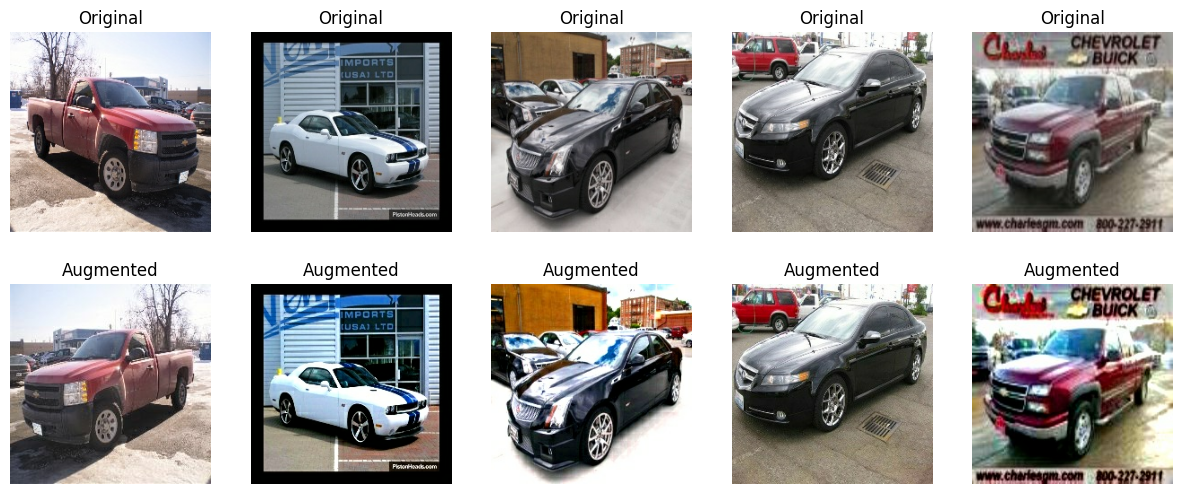

In [23]:
# הצגת 5 תמונות לפני ואחרי אוגמנטציה
fig, axes = plt.subplots(2, 5, figsize=(15, 6))

for i, (image, label) in enumerate(train_dataset.take(5)):
    aug_image, _ = augment(image, label)  # החלת האוגמנטציה

    axes[0, i].imshow(image.numpy())  # תמונה מקורית
    axes[0, i].set_title("Original")
    axes[0, i].axis("off")

    axes[1, i].imshow(aug_image.numpy())  # תמונה אחרי אוגמנטציה
    axes[1, i].set_title("Augmented")
    axes[1, i].axis("off")

plt.show()